# WTTE-RNN in PyTorch

Alex Kyllo

Based on original Keras version written by Egil Martinsson:
https://github.com/ragulpr/wtte-rnn/blob/master/examples/keras/simple_example.ipynb
MIT license

For details, check out
https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/
https://github.com/ragulpr/wtte-rnn

In [4]:
%matplotlib inline
import sys
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

sys.path.append("..")
from torch_wtte import losses

np.random.seed(11)
torch.manual_seed(11)

In [5]:
def get_data(n_timesteps, every_nth, n_repeats, noise_level, n_features, use_censored=True):
    def get_equal_spaced(n, every_nth):
        # create some simple data of evenly spaced events recurring every_nth step
        # Each is on (time,batch)-format
        events = np.array([np.array(range(n)) for _ in range(every_nth)])
        events = events + np.array(range(every_nth)).reshape(every_nth, 1) + 1

        tte_actual = every_nth - 1 - events % every_nth

        was_event = (events % every_nth == 0) * 1.0
        was_event[:, 0] = 0.0

        events = tte_actual == 0

        is_censored = (events[:, ::-1].cumsum(1)[:, ::-1] == 0) * 1
        tte_censored = is_censored[:, ::-1].cumsum(1)[:, ::-1] * is_censored
        tte_censored = tte_censored + (1 - is_censored) * tte_actual

        events = np.copy(events.T * 1.0)
        tte_actual = np.copy(tte_actual.T * 1.0)
        tte_censored = np.copy(tte_censored.T * 1.0)
        was_event = np.copy(was_event.T * 1.0)
        not_censored = 1 - np.copy(is_censored.T * 1.0)

        return tte_censored, not_censored, was_event, events, tte_actual

    tte_censored, not_censored, was_event, events, tte_actual = get_equal_spaced(
        n=n_timesteps, every_nth=every_nth
    )

    # From https://keras.io/layers/recurrent/
    # input shape rnn recurrent if return_sequences: (nb_samples, timesteps, input_dim)

    u_train = not_censored.T.reshape(n_sequences, n_timesteps, 1)
    x_train = was_event.T.reshape(n_sequences, n_timesteps, 1)
    tte_censored = tte_censored.T.reshape(n_sequences, n_timesteps, 1)
    y_train = np.append(tte_censored, u_train, axis=2)  # (n_sequences,n_timesteps,2)

    u_test = np.ones(shape=(n_sequences, n_timesteps, 1))
    x_test = np.copy(x_train)
    tte_actual = tte_actual.T.reshape(n_sequences, n_timesteps, 1)
    y_test = np.append(tte_actual, u_test, axis=2)  # (n_sequences,n_timesteps,2)

    if not use_censored:
        x_train = np.copy(x_test)
        y_train = np.copy(y_test)
    # Since the above is deterministic perfect fit is feasible.
    # More noise->more fun so add noise to the training data:

    x_train = np.tile(x_train.T, n_repeats).T
    y_train = np.tile(y_train.T, n_repeats).T

    # Try with more than one feature TODO
    x_train_new = np.zeros([x_train.shape[0], x_train.shape[1], n_features])
    x_test_new = np.zeros([x_test.shape[0], x_test.shape[1], n_features])
    for f in range(n_features):
        x_train_new[:, :, f] = x_train[:, :, 0]
        x_test_new[:, :, f] = x_test[:, :, 0]

    x_train = x_train_new
    x_test = x_test_new

    # xtrain is signal XOR noise with probability noise_level
    noise = np.random.binomial(1, noise_level, size=x_train.shape)
    x_train = x_train + noise - x_train * noise
    return y_train, x_train, y_test, x_test, events

### Generate some data

* The true event-sequence is evenly spaced points (but we start anywhere in the sequence)
* The true feature is (binary) if there was an event in last step
* In the training data the feature has added noise
* Training TTE is censored. Testing TTE is uncensored.

In [6]:
n_timesteps = 200
n_sequences = every_nth = 80
n_features = 1
n_repeats = 1000
noise_level = 0.005
use_censored = True

y_train, x_train, y_test, x_test, events = get_data(
    n_timesteps, every_nth, n_repeats, noise_level, n_features, use_censored
)

test shape (80, 200, 1) (80, 200, 2)


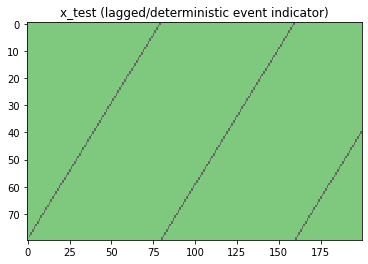

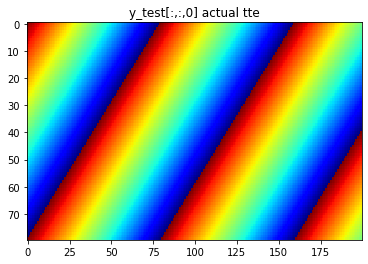

train shape (80000, 200, 1) (80000, 200, 2)


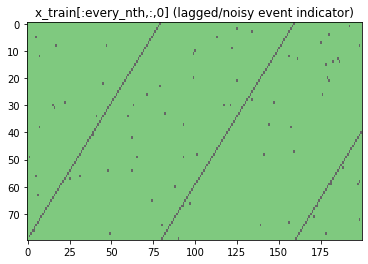

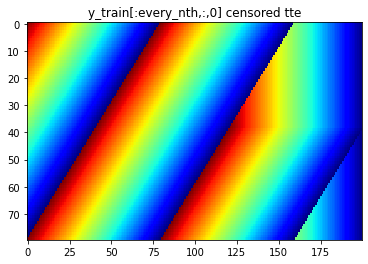

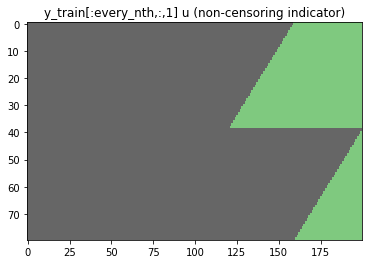

Example TTEs


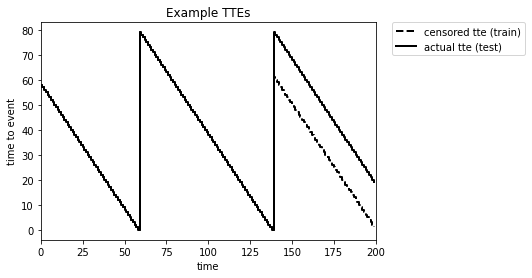

In [7]:
#### Plots
print("test shape", x_test.shape, y_test.shape)
plt.imshow(x_test[:, :, :].sum(axis=2) > 0, interpolation="none", cmap="Accent", aspect="auto")
plt.title("x_test (lagged/deterministic event indicator)")
plt.show()
plt.imshow(y_test[:, :, 0], interpolation="none", cmap="jet", aspect="auto")
plt.title("y_test[:,:,0] actual tte")
plt.show()

print("train shape", x_train.shape, y_train.shape)
plt.imshow(
    x_train[:every_nth, :, :].mean(axis=2), interpolation="none", cmap="Accent", aspect="auto"
)
plt.title("x_train[:every_nth,:,0] (lagged/noisy event indicator)")
plt.show()
plt.imshow(y_train[:every_nth, :, 0], interpolation="none", cmap="jet", aspect="auto")
plt.title("y_train[:every_nth,:,0] censored tte")
plt.show()
plt.imshow(y_train[:every_nth, :, 1], interpolation="none", cmap="Accent", aspect="auto")
plt.title("y_train[:every_nth,:,1] u (non-censoring indicator)")
plt.show()

## Example TTE:
print("Example TTEs")
plt.plot(
    y_train[every_nth // 4, :, 0],
    label="censored tte (train)",
    color="black",
    linestyle="dashed",
    linewidth=2,
    drawstyle="steps-post",
)
plt.plot(
    y_test[every_nth // 4, :, 0],
    label="actual tte (test)",
    color="black",
    linestyle="solid",
    linewidth=2,
    drawstyle="steps-post",
)

plt.xlim(0, n_timesteps)
plt.xlabel("time")
plt.ylabel("time to event")
plt.title("Example TTEs")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

# Train a WTTE-RNN
### Things to try out:
    * have fun with data paramaters:
        * every_nth to control event frequency
        * noise_level to make it more noisy
        * n_timesteps
        * n_features to get more noisy input
    * Generate more interesting temporal relationships
    * Here we use the smallest possible GRU. Try different learning rates, network architectures, initializations.
    * Try Implementing multivariate distributions, other distributions, data pipelines etc.
    * Invent better output activation layer
    * Invent ways to overcome instability with lots of censoring
    * ETC and have fun!

In [8]:
# Paramaeters for output activation layer initialization.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(y_train[:, :, 0])
init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
mean_u = np.nanmean(y_train[:, :, 1])
init_alpha = init_alpha / mean_u
print("init_alpha: ", init_alpha, "mean uncensored: ", mean_u)

### Uncomment if you have varying length sequences that is nanpadded to the right:
# mask_value = -1.3371337 # Use some improbable but not nan-causing telltale value
# x_train[:,:,:][np.isnan(x_train)] = mask_value
# y_train[:,:,0][np.isnan(y_train[:,:,0])] = tte_mean_train
# y_train[:,:,1][np.isnan(y_train[:,:,1])] = 0.5
# sample_weights = (x_train[:,:,0]!=mask_value)*1.

init_alpha:  43.44250429568219 mean uncensored:  0.8025


In [9]:
class WTTERNN(nn.Module):
    def __init__(self, discrete):
        super().__init__()
        self.epoch = 0
        self.layers = nn.ModuleList(
            [
                nn.GRU(input_size=n_features, hidden_size=2, batch_first=True),
                nn.Tanh(),
                losses.WeibullActivation(init_alpha=init_alpha, max_beta=4.0),
            ]
        )
        self.criterion = losses.WeibullCensoredNLLLoss(discrete=discrete)

    def forward(self, x):
        x, _ = self.layers[0](x)  # discard GRU hidden state output
        x = self.layers[1](x)
        x = self.layers[2](x)
        return x

    def fit(self, optimizer, train_loader, device="cpu"):
        num_batches = (
            len(train_loader.dataset) + train_loader.batch_size - 1
        ) // train_loader.batch_size
        self.to(device)
        self.train()
        train_losses = []
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = self(data).squeeze()
            tte = labels[..., 0]
            uncensored = labels[..., 1]
            alpha = output[..., 0]
            beta = output[..., 1]
            loss = self.criterion(tte, uncensored, alpha, beta).sum()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            avg_loss = loss / len(data)
            print(
                f"Epoch: {self.epoch} [batch {batch_idx+1}/{num_batches}]\tLoss: {loss.item():.6f} Avg Loss: {avg_loss:.6f}",
                end="\r",
            )
        avg_train_loss = np.sum(train_losses) / len(train_loader.dataset)
        print()
        self.epoch += 1
        return avg_train_loss

    def score(self, valid_loader, device="cpu"):
        self.to(device)
        self.eval()
        valid_loss = 0
        correct = 0
        with torch.no_grad():
            for data, labels in valid_loader:
                data, labels = data.to(device), labels.to(device)
                output = self(data).squeeze()
                tte = labels[..., 0]
                uncensored = labels[..., 1]
                alpha = output[..., 0]
                beta = output[..., 1]
                valid_loss = self.criterion(tte, uncensored, alpha, beta).sum().item()
                pred = output.data.round()
                correct += pred.eq(labels.data.view_as(pred)).sum()
        n = len(valid_loader.dataset)
        valid_loss /= n
        print(f"Validation: avg loss: {valid_loss:.4f}")
        return valid_loss

In [10]:
def run(x_train, y_train, x_test, y_test, epochs, device):
    print(f"Using device {device}")
    x_train = torch.from_numpy(x_train.astype("float32")).to(device)
    x_test = torch.from_numpy(x_test.astype("float32")).to(device)
    y_train = torch.from_numpy(y_train.astype("float32")).to(device)
    y_test = torch.from_numpy(y_test.astype("float32")).to(device)

    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    batch_size = x_train.shape[0] // 10
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = WTTERNN(discrete=True)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    train_loss_history = []
    valid_loss_history = []
    for _ in range(epochs):
        train_loss = model.fit(optimizer, train_loader, device=device)
        train_loss_history.append(train_loss)
        valid_loss = model.score(test_loader, device=device)
        valid_loss_history.append(valid_loss)
    return model, train_loss_history, valid_loss_history

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, train_losses, valid_losses = run(x_train, y_train, x_test, y_test, epochs=60, device=device)

Using device cuda:0
Epoch: 0 [batch 10/10]	Loss: 30105.781250 Avg Loss: 3.763223
Validation: avg loss: 4.5782
Epoch: 1 [batch 10/10]	Loss: 29993.214844 Avg Loss: 3.749152
Validation: avg loss: 4.5559
Epoch: 2 [batch 10/10]	Loss: 29888.449219 Avg Loss: 3.736056
Validation: avg loss: 4.5505
Epoch: 3 [batch 10/10]	Loss: 29839.753906 Avg Loss: 3.729970
Validation: avg loss: 4.5437
Epoch: 4 [batch 10/10]	Loss: 29813.664062 Avg Loss: 3.726708
Validation: avg loss: 4.5386
Epoch: 5 [batch 10/10]	Loss: 29799.527344 Avg Loss: 3.724941
Validation: avg loss: 4.5354
Epoch: 6 [batch 10/10]	Loss: 29784.562500 Avg Loss: 3.723070
Validation: avg loss: 4.5284
Epoch: 7 [batch 10/10]	Loss: 29685.361328 Avg Loss: 3.710670
Validation: avg loss: 4.5203
Epoch: 8 [batch 10/10]	Loss: 29633.103516 Avg Loss: 3.704138
Validation: avg loss: 4.5061
Epoch: 9 [batch 10/10]	Loss: 29474.597656 Avg Loss: 3.684325
Validation: avg loss: 4.4794
Epoch: 10 [batch 10/10]	Loss: 29095.273438 Avg Loss: 3.636909
Validation: avg lo

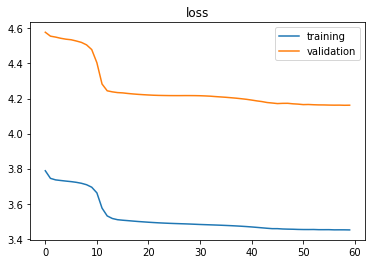

In [12]:
plt.plot(train_losses, label="training")
plt.plot(valid_losses, label="validation")
plt.title("loss")
plt.legend()

# Predictions
Try out training the model with different levels of noise. With more noise confidence gets lower (smaller beta). With less noise beta goes to maximum value and the predicted mode/peak probability is centered around the actual TTE.

TESTING (no noise in features)
(each horizontal line is a sequence)
(80, 200, 2)


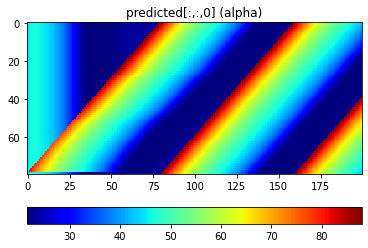

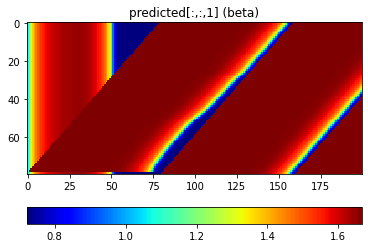

TRAINING (Noisy features)
(80, 200, 2)


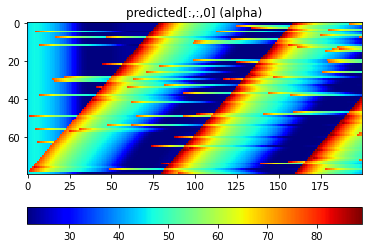

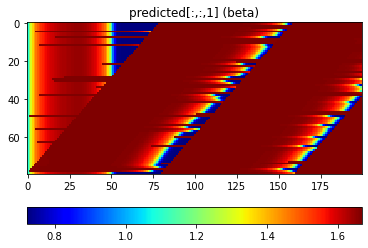

In [13]:
# Make some parametric predictions
print("TESTING (no noise in features)")
print("(each horizontal line is a sequence)")
predicted = model(torch.from_numpy(x_test.astype("float32")).to(device)).detach().cpu().numpy()
print(predicted.shape)

plt.imshow(predicted[:, :, 0], interpolation="none", cmap="jet", aspect="auto")
plt.title("predicted[:,:,0] (alpha)")
plt.colorbar(orientation="horizontal")
plt.show()
plt.imshow(predicted[:, :, 1], interpolation="none", cmap="jet", aspect="auto")
plt.title("predicted[:,:,1] (beta)")
plt.colorbar(orientation="horizontal")
plt.show()

print("TRAINING (Noisy features)")
predicted = (
    model(torch.from_numpy(x_train[:every_nth, :, :].astype("float32")).to(device))
    .detach()
    .cpu()
    .numpy()
)
print(predicted.shape)

plt.imshow(predicted[:, :, 0], interpolation="none", cmap="jet", aspect="auto")
plt.title("predicted[:,:,0] (alpha)")
plt.colorbar(orientation="horizontal")
plt.show()
plt.imshow(predicted[:, :, 1], interpolation="none", cmap="jet", aspect="auto")
plt.title("predicted[:,:,1] (beta)")
plt.colorbar(orientation="horizontal")
plt.show()